<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0_%D0%BF%D1%80%D0%B8_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D0%B8_API_Amazon_Rekognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание текста при помощи API Amazon Rekognition

# Text recognition using Amazon Rekognition API


До сих пор мы в основном фокусировались на использовании Tesseract. Однако существуют и другие системы оптического
распознавания символов, которые намного  точнее  


So far we have mainly focused on the use of Tesseract. However, there are other systems for optical
character recognition systems that are much more accurate  

В этой главе мы научимся использовать **API Amazon Rekognition** для распознавания изображений


In this chapter we will learn how to use **API Amazon Rekognition** for image recognition

 **API Amazon Rekognition** будет значительно лучше распознавать текст, однако в нем есть ряд своих минусов (как и в других облачных сервисах): 

  **API Amazon Rekognition** will be much better at text recognition, but it has a number of disadvantages (as with other cloud services): 


- всегда необходимо иметь подключение к интернету. you always need to have an internet connection. 
- это платная услуга, после преодоления определенного лимита. it is a paid service and you have to overcome a certain limit.
- результаты OCR занимают больше времени, поскольку изображение должно быть упаковано в запрос API. the OCR results take more time because the image has to be packed into the API request.
- тяжело использовать в режиме реального времени. it's hard to use in real time.

Мы будем использовать пакет **boto3** для взаимодействия с API 

We will use the **boto3** package to interact with the API 

## Реализация


## Implementation


In [1]:
# установим и распакуем архив
# install and unpack the archive
!wget http://dataudt.ru/datasets/cv/Lesson_19.Amazon_API_OCR.zip
!unzip -qq Lesson_19.Amazon_API_OCR.zip
%cd Amazon_API_OCR

--2022-02-11 06:34:57--  http://dataudt.ru/datasets/cv/Lesson_19.Amazon_API_OCR.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 486482 (475K) [application/zip]
Saving to: ‘Lesson_19.Amazon_API_OCR.zip’

Lesson_19.Amazon_AP 100%[===================>] 475.08K  2.28MB/s    in 0.2s    

2022-02-11 06:34:58 (2.28 MB/s) - ‘Lesson_19.Amazon_API_OCR.zip’ saved [486482/486482]

/content/Amazon_API_OCR


Для начала получим ключи. Для этого регистрируемся на официальном сайте https://aws.amazon.com/ru/

First, let's get the keys. To do this, we register on the official site https://aws.amazon.com/ru/

Там у нас будут запрашивать кредитку и номер телефона - это нормально. Все это делается ради подтверждения личности. 

There we will be asked for a credit card and phone number - this is normal. All this is done to confirm your identity. 


После успешной регистрации заходим на эту страничку http://console.aws.amazon.com/ и переходим в IAM







After successful registration, go to this page http://console.aws.amazon.com/ and go to IAM

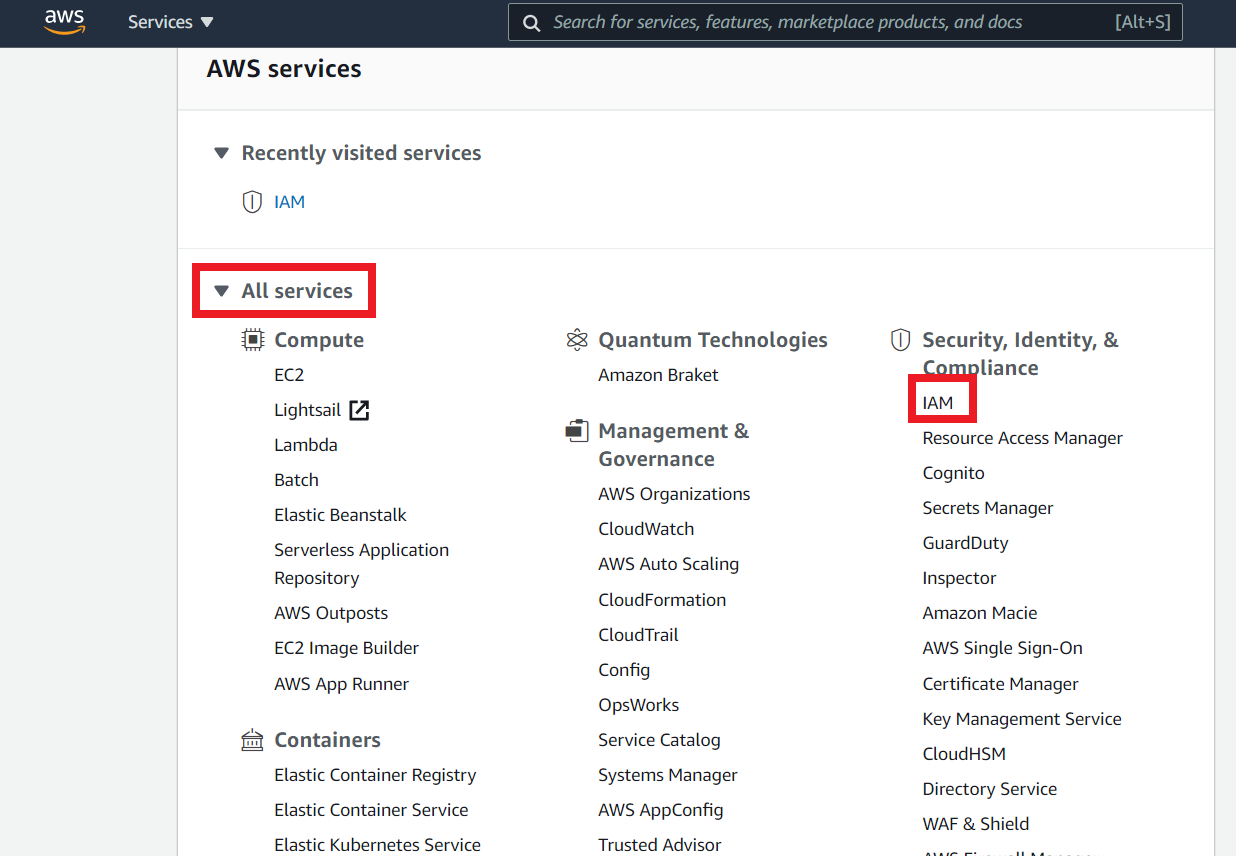

И там выбираем **My access key**

And there select **My access key**


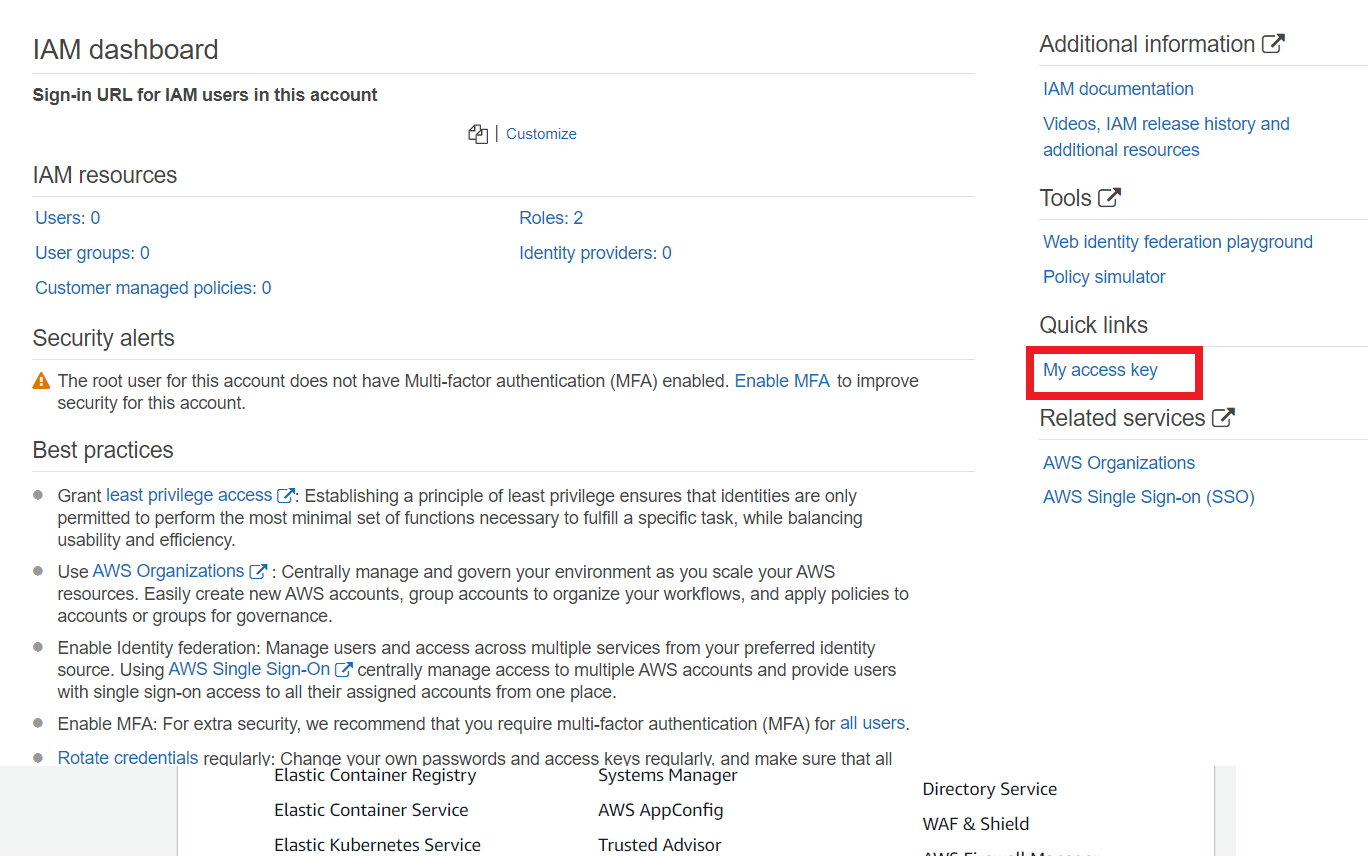

Далее генерируем новый ключ, нажимая на "**Create New Access Key**".

Next, generate a new key by clicking on "**Create New Access Key**".


Скачиваем файл ключа и сохраняем его в надежном месте. Он понадобится нам еще для получения доступа к службам AWS API. 

Download the key file and save it in a safe place. We will also need it to access the AWS API services.

Скачиваем дополнительную бибилиотеку boto3, через которую мы и будем обращаться к нашему API 








Download an additional library boto3, through which we will access our API 


In [2]:
!pip install boto3

     |████████████████████████████████| 132 kB 14.1 MB/s 
     |████████████████████████████████| 8.5 MB 44.8 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 138 kB 62.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.8 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Заполним конфигурационный файл. На месте пропусков вставьте свои значения 

Let's fill in the configuration file. In the place of the gaps insert your values 


In [ ]:
# define our AWS Access Key, Secret Key, and Region
# определяем ключ доступа к AWS, секретный ключ и регион
# ACCESS_KEY = "YOUR_ACCESS_KEY"
# SECRET_KEY = "YOUR_SECRET_KEY"
# REGION = "YOUR_AWS_REGION" # в качестве региона я указываю "us-west-1"
                            # I specify "us-west-1" as the region

Теперь напишем сам код 

Now let's write the code itself 


In [ ]:
# импортируем необходимые пакеты
# import the necessary packages
from google.colab.patches import cv2_imshow
import boto3
import cv2

In [ ]:
# функция, которая будет извлекать результаты
#  из Amazon Rekognition API и преобразовывать в читаемый вид 
# a function that will retrieve the results
# from Amazon Rekognition API and convert to human readable
def draw_ocr_results(image, text, poly, color=(0, 255, 0)):
    # распаковываем ограничивающую рамку,
    #  позаботившись о масштабировании координат
    #  относительно размера входного изображения
    # unpack the bounding box, taking care to scale the coordinates
	# relative to the input image size
	(h, w) = image.shape[:2]
	tlX = int(poly[0]["X"] * w)
	tlY = int(poly[0]["Y"] * h)
	trX = int(poly[1]["X"] * w)
	trY = int(poly[1]["Y"] * h)
	brX = int(poly[2]["X"] * w)
	brY = int(poly[2]["Y"] * h)
	blX = int(poly[3]["X"] * w)
	blY = int(poly[3]["Y"] * h)

    # строим список точек и используем его для 
    # построения каждой вершины ограничительной рамки
    # build a list of points and use it to construct each vertex
	# of the bounding box
	pts = ((tlX, tlY), (trX, trY), (brX, brY), (blX, blY))
	topLeft = pts[0]
	topRight = pts[1]
	bottomRight = pts[2]
	bottomLeft = pts[3]

    # рисуем ограничивающую рамку обнаруженного текста
    # draw the bounding box of the detected text
	cv2.line(image, topLeft, topRight, color, 2)
	cv2.line(image, topRight, bottomRight, color, 2)
	cv2.line(image, bottomRight, bottomLeft, color, 2)
	cv2.line(image, bottomLeft, topLeft, color, 2)

    # рисуем сам текст
    # draw the text itself
	cv2.putText(image, text, (topLeft[0], topLeft[1] - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # возвращаем выходное изображение
    # return the output image
	return image


In [ ]:
# создадим отдельный словарь с аргументами 
# create a separate dictionary with arguments 

args = {
  "image" : "/content/Amazon_API_OCR/images/ex1.jpg", # путь к входному изображению 
                                                    # the path to the input image 
  "type": "line", # тип выводимого текста (либо "line", либо "word")
                     # type of output text (either "line" or "word")
  
}

In [ ]:
# мы подключаемся к AWS, чтобы использовать Rekognition OCR API
# connect to AWS so we can use the Rekognition OCR API
client = boto3.client(
	"rekognition",
	aws_access_key_id=ACCESS_KEY,
	aws_secret_access_key=SECRET_KEY,
	region_name=REGION)

# загружаем входное изображение в виде необработанного
#  двоичного файла и делаем запрос к API Rekognition OCR
# load the input image as a raw binary file and make a request to
# the Rekognition OCR API
print("[INFO] making request to AWS Rekognition API...")
image = open(args["image"], "rb").read()
response = client.detect_text(Image={"Bytes": image})

# получаем результаты обнаружения текста из
#  API и снова загружаем входное изображение,
#  на этот раз в формате OpenCV
# grab the text detection results from the API and load the input
# image again, this time in OpenCV format
detections = response["TextDetections"]
image = cv2.imread(args["image"])

# делаем копию входного изображения для 
# окончательного вывода
# make a copy of the input image for final output
final = image.copy()

# перебираем ограничивающие рамки 
# loop over the text detection bounding boxes
for detection in detections:
    # извлекаем распознанный текст,
    #  тип текста и координаты ограничивающей рамки
    # extract the OCR'd text, text type, and bounding box coordinates
	text = detection["DetectedText"]
	textType = detection["Type"]
	poly = detection["Geometry"]["Polygon"]

    # показываем результат процесса OCR,
    #  только если мы смотрим на правильный тип текста
    # only draw show the output of the OCR process if we are looking
	# at the correct text type
	if args["type"] == textType.lower():
        # рисуем выходной OCR построчно
        # draw the output OCR line-by-line
		output = image.copy()
		output = draw_ocr_results(output, text, poly)
		final = draw_ocr_results(final, text, poly)

        # показываем выходную строку
        # show the output OCR'd line
		print(text)
		cv2_imshow( output)

# выводим конечное выходное изображение
# show the final output image
print('Final')
cv2_imshow(final)